In [59]:
import os
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime
from matplotlib import gridspec
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 13,   # X-axis tick labels
    'ytick.labelsize' : 13,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)

<module 'compute_ensemble_stats' from '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC/compute_ensemble_stats.py'>

In [60]:
# ------ midlatitude average

freq='monthly'
pmin, pmax = 2, 100
mass = [3,5,7,10,13,15]
N    = len(mass)
aoa_scaling = {'cfmean':1/360, 'ensmean':1/360, 'impact':1/30, 'pval':1, 'coherence':1}
e90_scaling = {'cfmean':1e9, 'ensmean':1e9, 'impact':1e9, 'pval':1, 'coherence':1}

latmin, latmax = 20, 40
aoaargs = {'skip_nosrctag':True, 'freq':freq, 'pass_var':True,
           'latmin':latmin, 'latmax':latmax, 'pmin':pmin, 'pmax':pmax,
           'average_lat':True, 'average_time':False, 'average_pres':False}
e90args = copy.copy(aoaargs)
e90args['tmin'], e90args['tmax'] = date(1991,6,1), date(1996,6,1)

# ----- NH
aoa_nh = [None]*N
e90_nh = [None]*N
for i in range(N):
    aoa_nh[i] = putil.get_variable('AOA', **aoaargs, mass=mass[i])
    e90_nh[i] = putil.get_variable('E90j', **e90args, mass=mass[i])
    for ds in aoa_nh[i].keys():
        aoa_nh[i][ds] = aoa_nh[i][ds]*aoa_scaling[ds]
        e90_nh[i][ds] = e90_nh[i][ds]*e90_scaling[ds]

# ----- SH
aoaargs['latmin'], aoaargs['latmax'] = -latmax, -latmin
e90args['latmin'], e90args['latmax'] = -latmax, -latmin
aoa_sh = [None]*N
e90_sh = [None]*N
for i in range(N):
    aoa_sh[i] = putil.get_variable('AOA', **aoaargs, mass=mass[i])
    e90_sh[i] = putil.get_variable('E90j', **e90args, mass=mass[i])
    for ds in aoa_nh[i].keys():
        aoa_sh[i][ds] = aoa_sh[i][ds]*aoa_scaling[ds]
        e90_sh[i][ds] = e90_sh[i][ds]*e90_scaling[ds]

print('done')

done


In [86]:
def plot_impact(ax, pp, hh, var, legend=True):
    
    if(var=='aoa'):
        data   = {'NH':aoa_nh, 'SH':aoa_sh}[hh]
        mass_cmap = plt.cm.plasma_r
    if(var=='e90'):
        data   = ({'NH':e90_nh, 'SH':e90_sh}[hh])
        mass_cmap = plt.cm.viridis_r
    impact = [d['impact'].sel(plev=pp, method='nearest') for d in data]
    sig    = [d['pval'].sel(plev=pp, method='nearest') < 0.05 for d in data]
    sig    = [impact[i].where(sig[i]) for i in range(N)]
        
    # ---- dims
    time = [datetime(t.year, t.month, t.day) for t in data[0]['impact'].time.values]

    # ---- plotting settings
    if(hh=='NH'): title = 'NH ${}^\\circ$N$-{}^\\circ$N, {} hPa'.format(latmin, latmax, pp)
    if(hh=='SH'): title = 'SH ${}^\\circ$S$-{}^\\circ$S, {} hPa'.format(latmin, latmax, pp)
    mass_colors = mass_cmap(np.linspace(0.15, 1, N))
    mass_lw = np.ones(N)*2
    mass_ls = [':', '-.', '--', ':', '-.', '-']
    slw = 10
    salph = 0.2

    # ------ plot
    for i in range(N):
        ax.plot(time, sig[i], color=mass_colors[i], lw=slw, alpha=salph)
        ax.plot(time, impact[i], color=mass_colors[i], lw=mass_lw[i], ls=mass_ls[i], label='{} Tg'.format(mass[i]))

    # ---- format
    if(legend):
        ax.legend(loc='best', fancybox=False, fontsize=14, ncol=2)

    ylim = ax.get_ylim()
    ax.fill_between(x=time, y1=ylim[0], y2=[0], color='grey', alpha=0.15)
    ax.set_ylim(ylim)

    ax.set_xlim([time[0], time[-1]])
    putil.season_timeticks(ax=ax, option='year', times=time)

# ------------------------------------------------------
    
def plot_impact_trend(ax, pp, hh, var, legend=True):
    
    if(var=='aoa'):
        data = {'NH':aoa_nh, 'SH':aoa_sh}[hh]
        mass_cmap = plt.cm.plasma_r
    if(var=='e90'):
        data = ({'NH':e90_nh, 'SH':e90_sh}[hh])
        mass_cmap = plt.cm.viridis_r
    impact = [d['impact'].sel(plev=pp, method='nearest') for d in data]
    imax   = [abs(d).argmax('time') for d in impact]
    impact = np.array([float(impact[i].isel(time=imax[i]).values) for i in range(N)])
    impact = impact/impact[-1]
    
    # ---- dims
    time = [datetime(t.year, t.month, t.day) for t in data[0]['impact'].time.values]
    
    # ---- plotting settings
    color, lw, ls, marker, ms = 'k', 2, '-', 'o', 8

    # ------ plot
    ax.plot(mass, impact, color=color, lw=lw, ls=ls, marker=marker, ms=ms)
    
    # ----- format
    ax.xaxis.set_ticks(mass)
    
# ------------------------------------------------------

test=False
if(test):
    pp,hh=10,'NH'
    fig,ax=plt.subplots()
    plot_impact(ax,pp,hh,'aoa')
    fig,ax=plt.subplots()
    plot_impact_trend(ax,pp,hh,'aoa')
    plt.show()

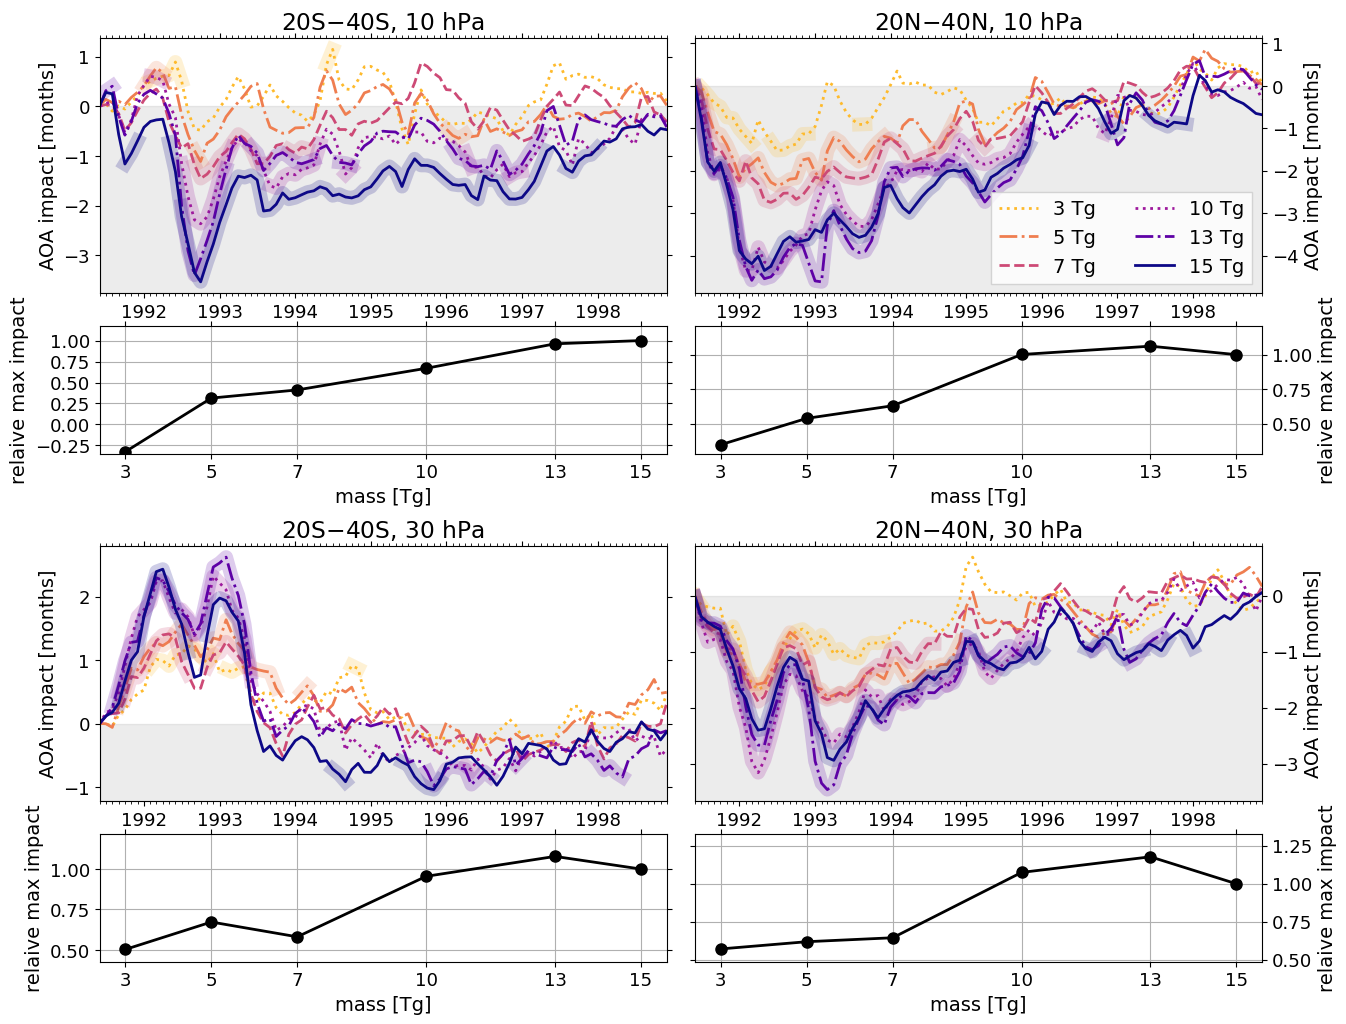

In [87]:
# ---- choose pressure level and hemisphere, get data, significance
var = 'aoa'
fig = plt.figure(figsize=(15,12))
gs  = fig.add_gridspec(2, 2, hspace=0.22, wspace=0.05)
hr = [2,1]
hs = 0.17
gs1 = gs[0, 0].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs2 = gs[0, 1].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs3 = gs[1, 0].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs4 = gs[1, 1].subgridspec(2, 1, height_ratios=hr, hspace=hs)

ax1i, ax1t  = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax2i, ax2t  = fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1])
ax3i, ax3t  = fig.add_subplot(gs3[0]), fig.add_subplot(gs3[1])
ax4i, ax4t  = fig.add_subplot(gs4[0]), fig.add_subplot(gs4[1])

axi = [ax1i, ax2i, ax3i, ax4i]
axt = [ax1t, ax2t, ax3t, ax4t]
for j in range(len(axi)):
    if(j==1 or j==3): y='right'
    else:             y='left'
    putil.format_ticks(axi[j], y=y)
    putil.format_ticks(axt[j], y=y)
    axt[j].grid()

pp = [10, 10, 30, 30]
hh = ['SH', 'NH', 'SH', 'NH']
for j in range(len(axi)):
    legend=[False, True][j==1]
    plot_impact(axi[j], pp[j], hh[j], var, legend=legend)
    plot_impact_trend(axt[j], pp[j], hh[j], var, legend=legend)
    if(hh[j]=='NH'): title = '{}N$-${}N, {} hPa'.format(latmin, latmax, pp[j])
    if(hh[j]=='SH'): title = '{}S$-${}S, {} hPa'.format(latmin, latmax, pp[j])
    axi[j].set_title(title)
    ylim, yf = axt[j].get_ylim(), 0.1
    axt[j].yaxis.set_ticks(np.arange(-1.5,1.51,0.25))
    axt[j].set_ylim([ylim[0]-ylim[0]*yf, ylim[1]+ylim[1]*yf])
    #axt[j].set_ylim([-0.1, 1.25])
    axi[j].set_ylabel('AOA impact [months]')
    axt[j].set_ylabel('relaive max impact')
    axt[j].set_xlabel('mass [Tg]')

plt.savefig('figs/aoa_mass_sensitivity.pdf', dpi=250, bbox_inches='tight')
plt.show()

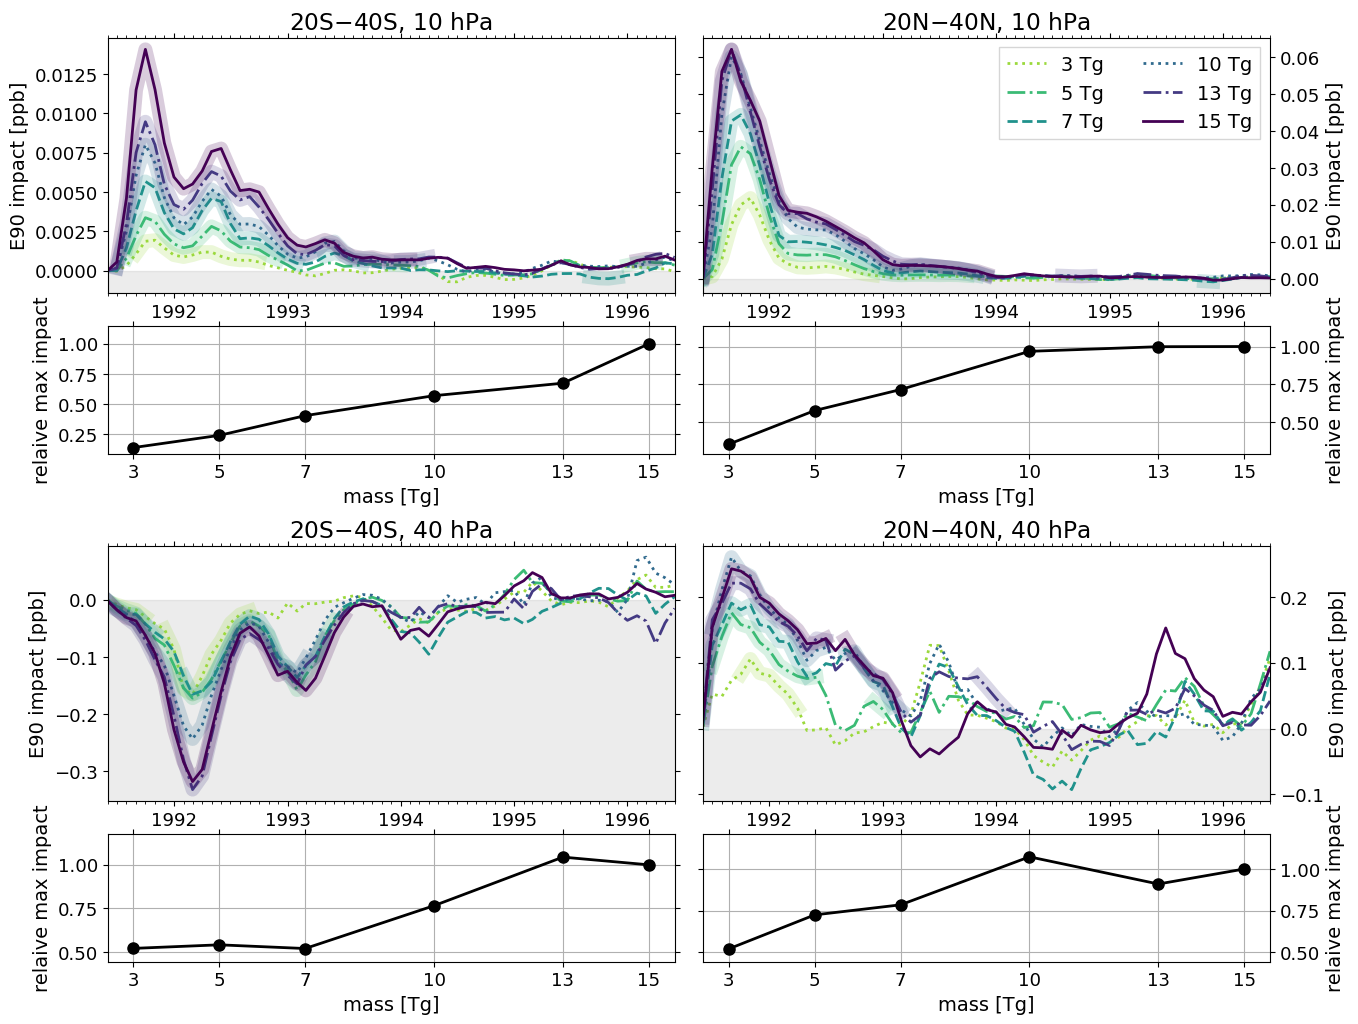

In [88]:
# ---- choose pressure level and hemisphere, get data, significance
var = 'e90'
fig = plt.figure(figsize=(15,12))
gs  = fig.add_gridspec(2, 2, hspace=0.22, wspace=0.05)
hr = [2,1]
hs = 0.17
gs1 = gs[0, 0].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs2 = gs[0, 1].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs3 = gs[1, 0].subgridspec(2, 1, height_ratios=hr, hspace=hs)
gs4 = gs[1, 1].subgridspec(2, 1, height_ratios=hr, hspace=hs)

ax1i, ax1t  = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax2i, ax2t  = fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1])
ax3i, ax3t  = fig.add_subplot(gs3[0]), fig.add_subplot(gs3[1])
ax4i, ax4t  = fig.add_subplot(gs4[0]), fig.add_subplot(gs4[1])

axi = [ax1i, ax2i, ax3i, ax4i]
axt = [ax1t, ax2t, ax3t, ax4t]
for j in range(len(axi)):
    if(j==1 or j==3): y='right'
    else:             y='left'
    putil.format_ticks(axi[j], y=y)
    putil.format_ticks(axt[j], y=y)
    axt[j].grid()

pp = [10, 10, 40, 40]
hh = ['SH', 'NH', 'SH', 'NH']
for j in range(len(axi)):
    legend=[False, True][j==1]
    plot_impact(axi[j], pp[j], hh[j], var, legend=legend)
    plot_impact_trend(axt[j], pp[j], hh[j], var, legend=legend)
    if(hh[j]=='NH'): title = '{}N$-${}N, {} hPa'.format(latmin, latmax, pp[j])
    if(hh[j]=='SH'): title = '{}S$-${}S, {} hPa'.format(latmin, latmax, pp[j])
    axi[j].set_title(title)
    ylim, yf = axt[j].get_ylim(), 0.1
    axt[j].yaxis.set_ticks(np.arange(-1.5,1.51,0.25))
    axt[j].set_ylim([ylim[0]-ylim[0]*yf, ylim[1]+ylim[1]*yf])
    #axt[j].set_ylim([-0.1, 1.25])
    axi[j].set_ylabel('E90 impact [ppb]')
    axt[j].set_ylabel('relaive max impact')
    axt[j].set_xlabel('mass [Tg]')

plt.savefig('figs/e90_mass_sensitivity.pdf', dpi=250, bbox_inches='tight')
plt.show()